In [1]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2a94207b3d5dbef6f71f0e8167561b06fb6fc618ee373a491c4cbc75f1f39149
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=85843951bd883bab2aece6e76f0c0da8af9f7058a130c58a888c02f4d7ea5ebb
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [2]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augmentations=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])
        
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) 
        
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
    
        image = image.float()
        mask = (mask > 0).float()  
        mask = mask.unsqueeze(0)  
        
        return image, mask

image_dir = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images"
mask_dir = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks"


In [4]:
train_augmentations = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ToTensorV2(),
])

val_test_augmentations = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

full_dataset = SegmentationDataset(
    image_dir=image_dir, 
    mask_dir=mask_dir, 
    augmentations=train_augmentations
)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

val_dataset.dataset.augmentations = val_test_augmentations
test_dataset.dataset.augmentations = val_test_augmentations

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
model = smp.Unet(
    encoder_name="resnet101",     
    encoder_weights="imagenet",   
    in_channels=3,                
    classes=1                     
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 133MB/s]


In [6]:
# Metrics
def calculate_miou(pred, mask, smooth=1e-10):
    pred = (pred > 0.5).float()  
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() - intersection
    miou = (intersection + smooth) / (union + smooth)
    return miou

def calculate_dice_loss(pred, mask, smooth=1e-10):
    pred = pred.sigmoid()  
    intersection = (pred * mask).sum()
    dice = (2.0 * intersection + smooth) / (pred.sum() + mask.sum() + smooth)
    return 1 - dice 

def calculate_pixel_accuracy(pred, mask):
    pred = (pred > 0.5).float()
    correct = (pred == mask).sum()
    total = torch.numel(mask)
    return correct / total

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_miou = 0
    train_dice = 0
    train_pixel_acc = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for images, masks in train_loader_tqdm:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_miou += calculate_miou(outputs.sigmoid(), masks).item()
        train_dice += calculate_dice_loss(outputs, masks).item()
        train_pixel_acc += calculate_pixel_accuracy(outputs.sigmoid(), masks).item()

        train_loader_tqdm.set_postfix({"Loss": loss.item()})

    train_loss /= len(train_loader)
    train_miou /= len(train_loader)
    train_dice = 1 - (train_dice / len(train_loader))  
    train_pixel_acc /= len(train_loader)

    model.eval()
    val_loss = 0
    val_miou = 0
    val_dice = 0
    val_pixel_acc = 0
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_miou += calculate_miou(outputs.sigmoid(), masks).item()
            val_dice += calculate_dice_loss(outputs, masks).item()
            val_pixel_acc += calculate_pixel_accuracy(outputs.sigmoid(), masks).item()

            val_loader_tqdm.set_postfix({"Loss": loss.item()})

    val_loss /= len(val_loader)
    val_miou /= len(val_loader)
    val_dice = 1 - (val_dice / len(val_loader))
    val_pixel_acc /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f}, Train mIoU: {train_miou:.4f}, Train Dice: {train_dice:.4f}, Train Pixel Acc: {train_pixel_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}, Val Dice: {val_dice:.4f}, Val Pixel Acc: {val_pixel_acc:.4f}")

torch.save(model.state_dict(), "unet_resnet101_augmented.pth")


Epoch 1/20


Train Loss: 0.4975, Train mIoU: 0.4883, Train Dice: 0.5049, Train Pixel Acc: 0.7827
Val Loss: 0.3818, Val mIoU: 0.6833, Val Dice: 0.6009, Val Pixel Acc: 0.8797
Epoch 2/20


Train Loss: 0.3413, Train mIoU: 0.7481, Train Dice: 0.6284, Train Pixel Acc: 0.9080
Val Loss: 0.3011, Val mIoU: 0.7912, Val Dice: 0.6606, Val Pixel Acc: 0.9266
Epoch 3/20


Train Loss: 0.2743, Train mIoU: 0.8266, Train Dice: 0.6882, Train Pixel Acc: 0.9393
Val Loss: 0.2538, Val mIoU: 0.8340, Val Dice: 0.7004, Val Pixel Acc: 0.9436
Epoch 4/20


Train Loss: 0.2365, Train mIoU: 0.8610, Train Dice: 0.7241, Train Pixel Acc: 0.9526
Val Loss: 0.2341, Val mIoU: 0.8524, Val Dice: 0.7323, Val Pixel Acc: 0.9491
Epoch 5/20


Train Loss: 0.2069, Train mIoU: 0.8886, Train Dice: 0.7533, Train Pixel Acc: 0.9626
Val Loss: 0.2096, Val mIoU: 0.8705, Val Dice: 0.7522, Val Pixel Acc: 0.9566
Epoch 6/20


Train Loss: 0.1875, Train mIoU: 0.9031, Train Dice: 0.7734, Train Pixel Acc: 0.9677
Val Loss: 0.1935, Val mIoU: 0.8809, Val Dice: 0.7739, Val Pixel Acc: 0.9599
Epoch 7/20


Train Loss: 0.1702, Train mIoU: 0.9158, Train Dice: 0.7910, Train Pixel Acc: 0.9723
Val Loss: 0.1804, Val mIoU: 0.8904, Val Dice: 0.7864, Val Pixel Acc: 0.9634
Epoch 8/20


Train Loss: 0.1570, Train mIoU: 0.9248, Train Dice: 0.8046, Train Pixel Acc: 0.9755
Val Loss: 0.1701, Val mIoU: 0.8960, Val Dice: 0.7984, Val Pixel Acc: 0.9654
Epoch 9/20


Train Loss: 0.1438, Train mIoU: 0.9345, Train Dice: 0.8189, Train Pixel Acc: 0.9789
Val Loss: 0.1605, Val mIoU: 0.8989, Val Dice: 0.8103, Val Pixel Acc: 0.9664
Epoch 10/20


Train Loss: 0.1337, Train mIoU: 0.9404, Train Dice: 0.8301, Train Pixel Acc: 0.9808
Val Loss: 0.1546, Val mIoU: 0.9040, Val Dice: 0.8172, Val Pixel Acc: 0.9684
Epoch 11/20


Train Loss: 0.1246, Train mIoU: 0.9454, Train Dice: 0.8403, Train Pixel Acc: 0.9824
Val Loss: 0.1444, Val mIoU: 0.9072, Val Dice: 0.8281, Val Pixel Acc: 0.9694
Epoch 12/20


Train Loss: 0.1166, Train mIoU: 0.9489, Train Dice: 0.8497, Train Pixel Acc: 0.9836
Val Loss: 0.1407, Val mIoU: 0.9077, Val Dice: 0.8353, Val Pixel Acc: 0.9696
Epoch 13/20


Train Loss: 0.1105, Train mIoU: 0.9509, Train Dice: 0.8565, Train Pixel Acc: 0.9843
Val Loss: 0.1356, Val mIoU: 0.9096, Val Dice: 0.8428, Val Pixel Acc: 0.9702
Epoch 14/20


Train Loss: 0.1032, Train mIoU: 0.9551, Train Dice: 0.8652, Train Pixel Acc: 0.9856
Val Loss: 0.1282, Val mIoU: 0.9128, Val Dice: 0.8509, Val Pixel Acc: 0.9714
Epoch 15/20


Train Loss: 0.0981, Train mIoU: 0.9559, Train Dice: 0.8716, Train Pixel Acc: 0.9859
Val Loss: 0.1252, Val mIoU: 0.9132, Val Dice: 0.8572, Val Pixel Acc: 0.9716
Epoch 16/20


Train Loss: 0.0914, Train mIoU: 0.9599, Train Dice: 0.8798, Train Pixel Acc: 0.9872
Val Loss: 0.1199, Val mIoU: 0.9160, Val Dice: 0.8640, Val Pixel Acc: 0.9723
Epoch 17/20


Train Loss: 0.0865, Train mIoU: 0.9616, Train Dice: 0.8855, Train Pixel Acc: 0.9878
Val Loss: 0.1162, Val mIoU: 0.9171, Val Dice: 0.8691, Val Pixel Acc: 0.9728
Epoch 18/20


Train Loss: 0.0825, Train mIoU: 0.9630, Train Dice: 0.8903, Train Pixel Acc: 0.9883
Val Loss: 0.1115, Val mIoU: 0.9172, Val Dice: 0.8744, Val Pixel Acc: 0.9730
Epoch 19/20


Train Loss: 0.0781, Train mIoU: 0.9647, Train Dice: 0.8962, Train Pixel Acc: 0.9888
Val Loss: 0.1082, Val mIoU: 0.9185, Val Dice: 0.8791, Val Pixel Acc: 0.9734
Epoch 20/20


Train Loss: 0.0751, Train mIoU: 0.9648, Train Dice: 0.8996, Train Pixel Acc: 0.9890
Val Loss: 0.1122, Val mIoU: 0.9167, Val Dice: 0.8822, Val Pixel Acc: 0.9725


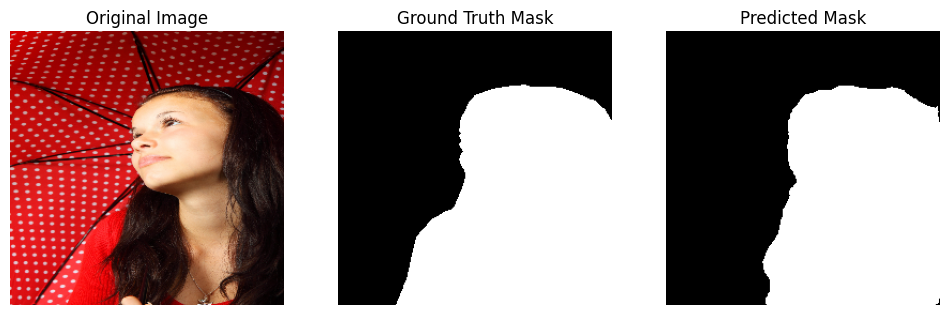

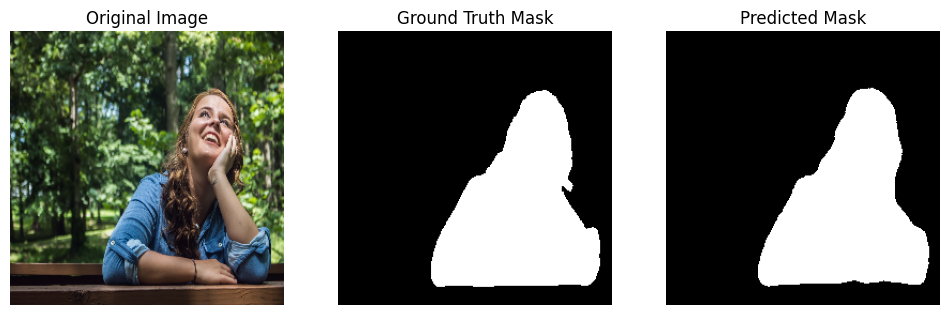

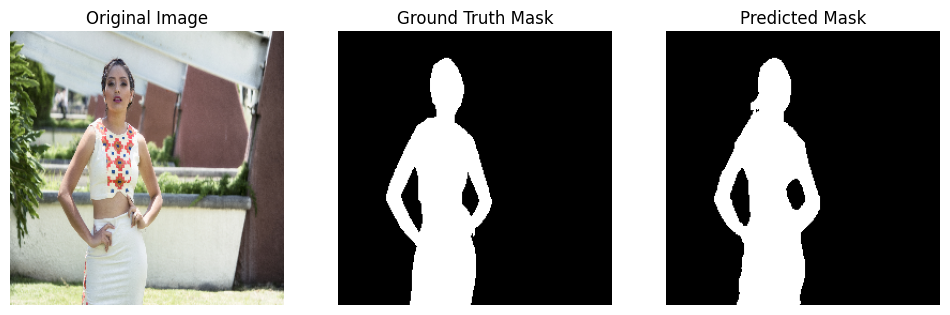

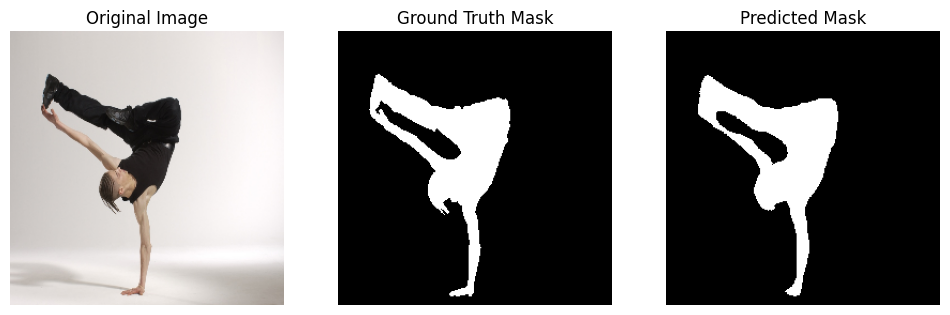

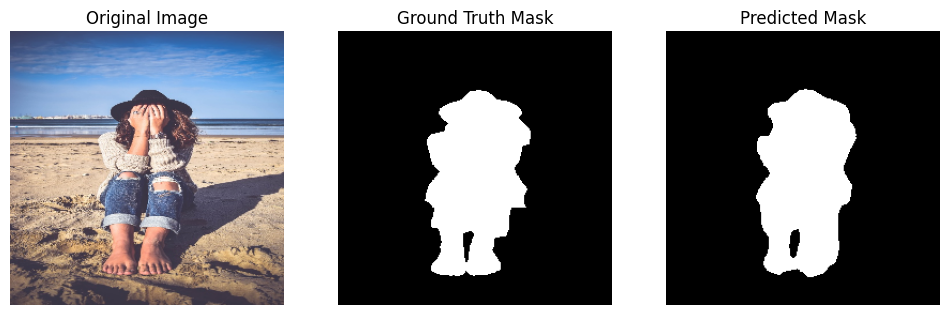

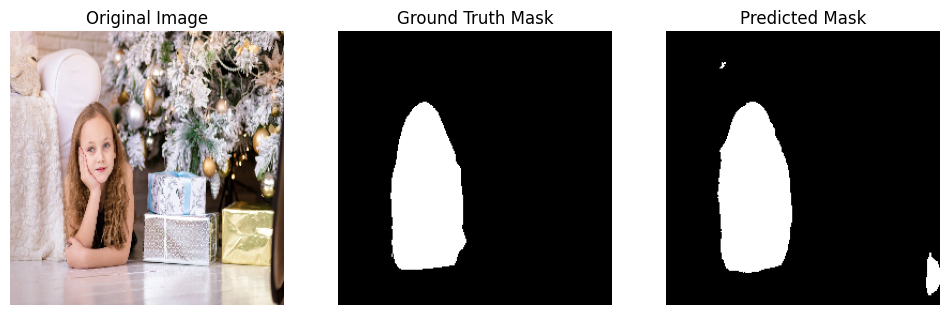

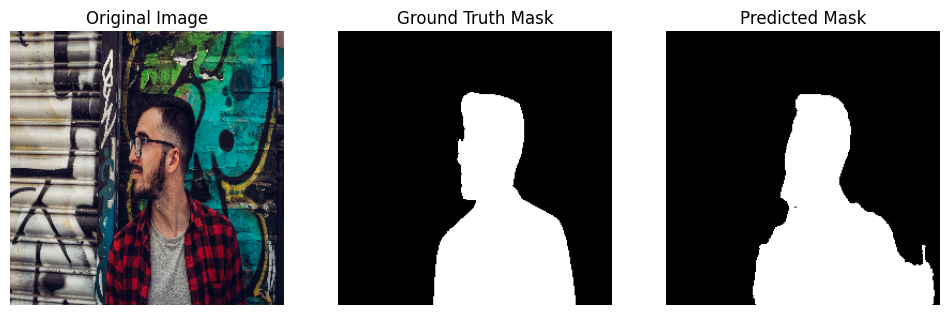

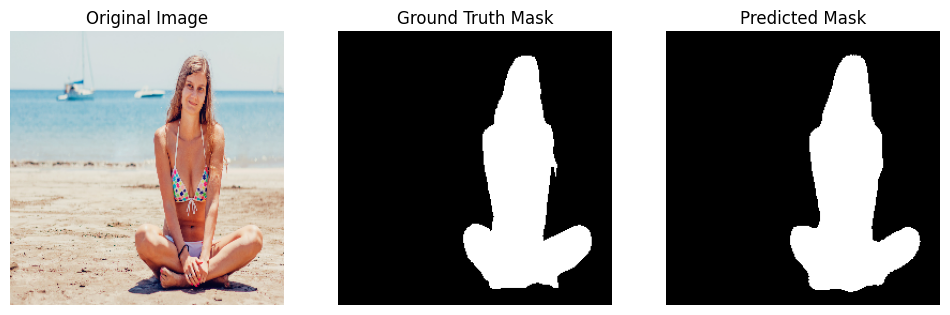

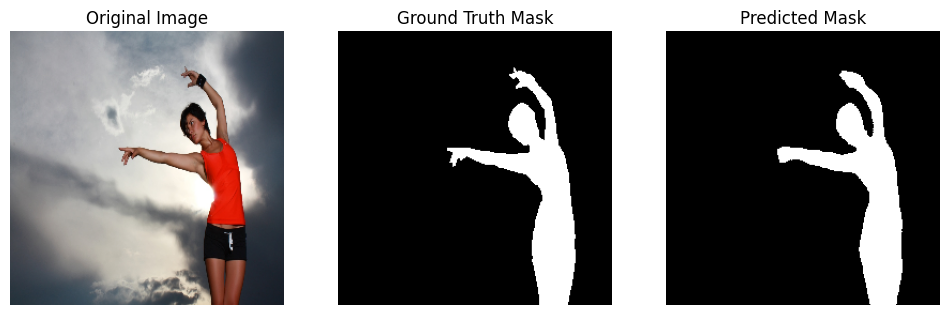

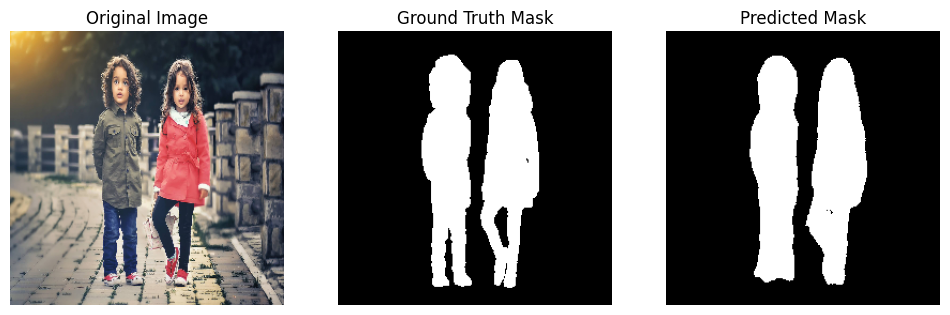

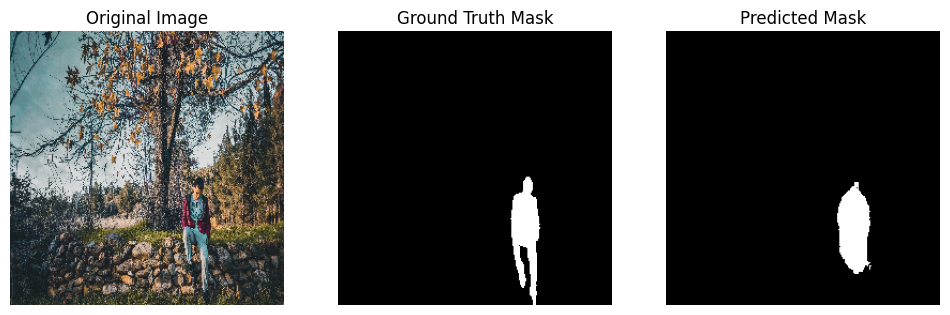

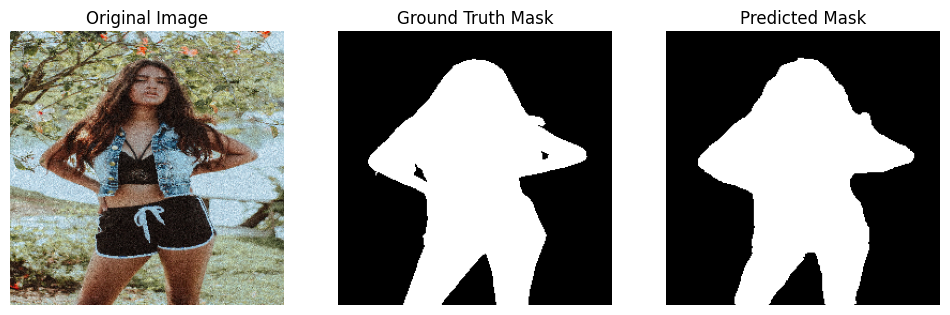

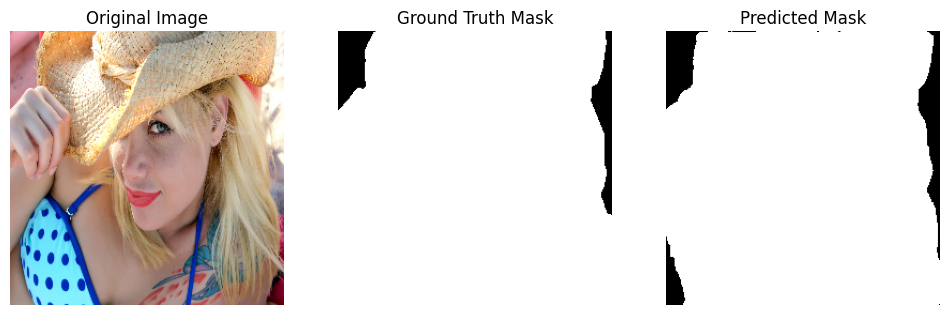

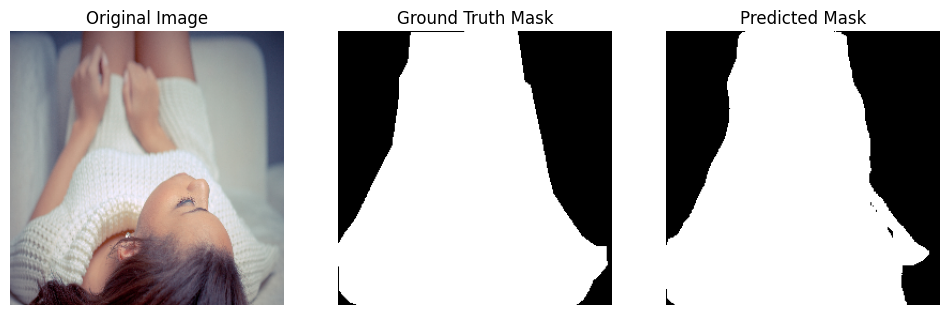

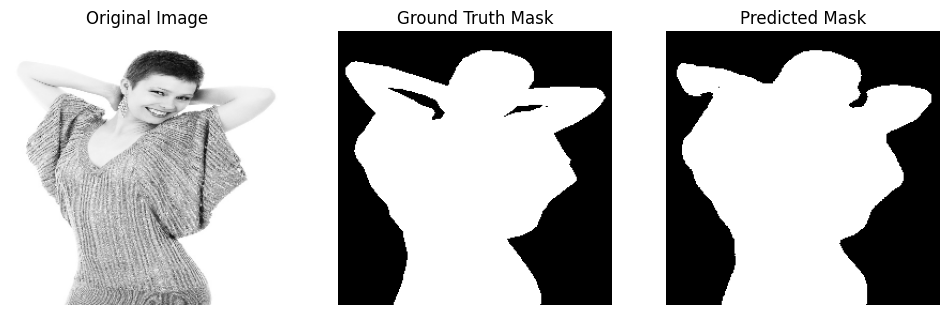

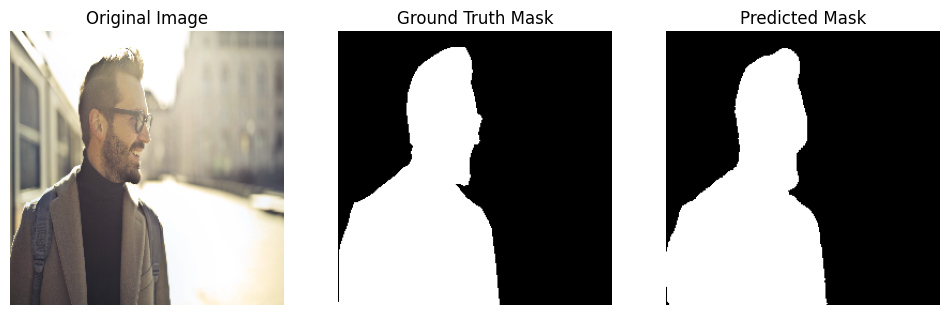

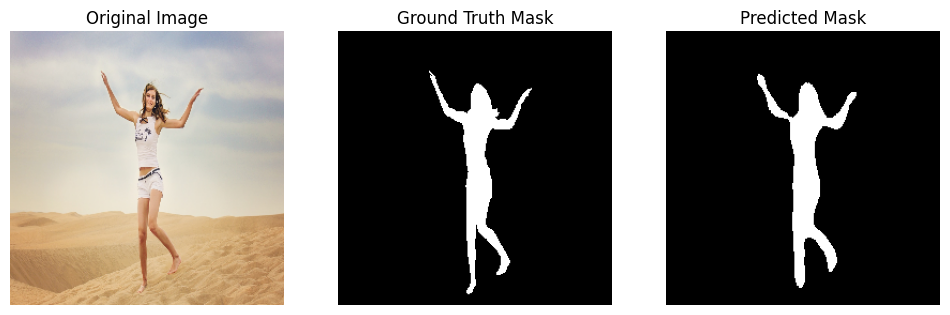

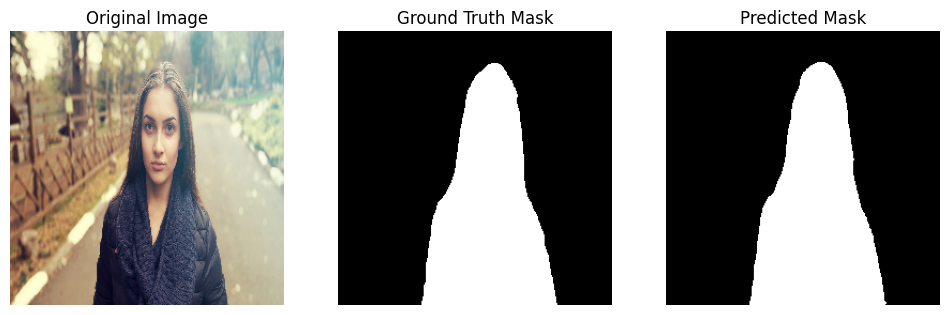

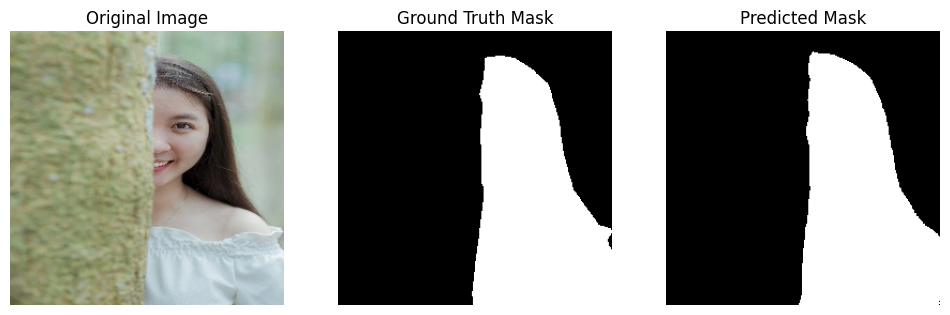

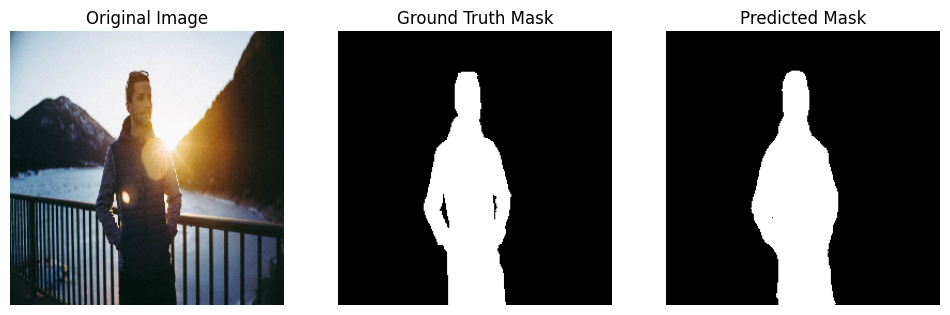

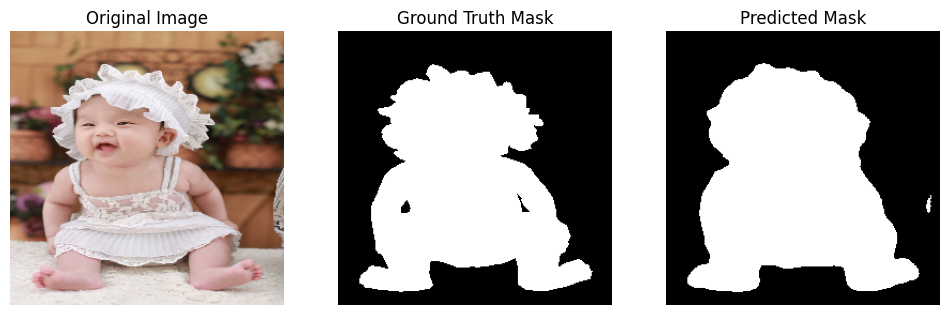

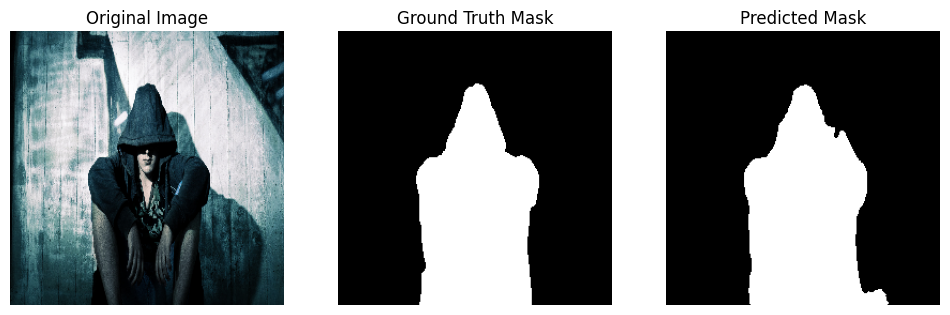

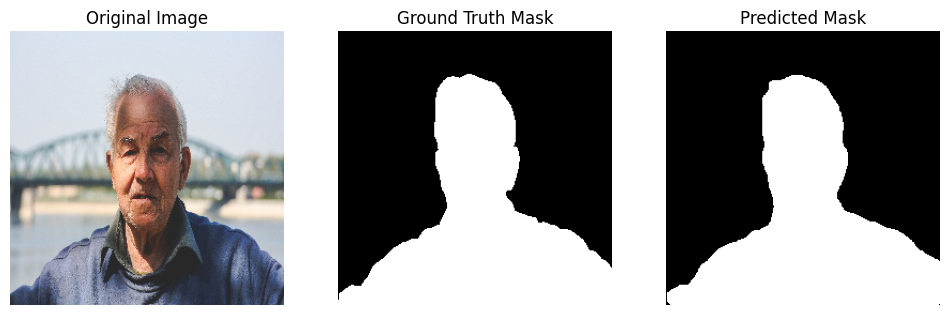

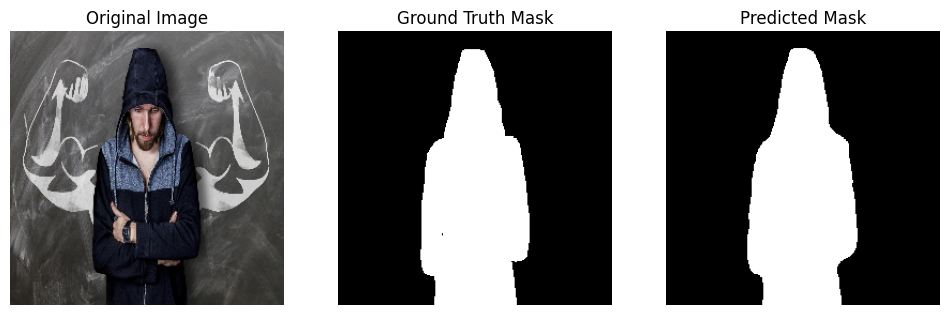

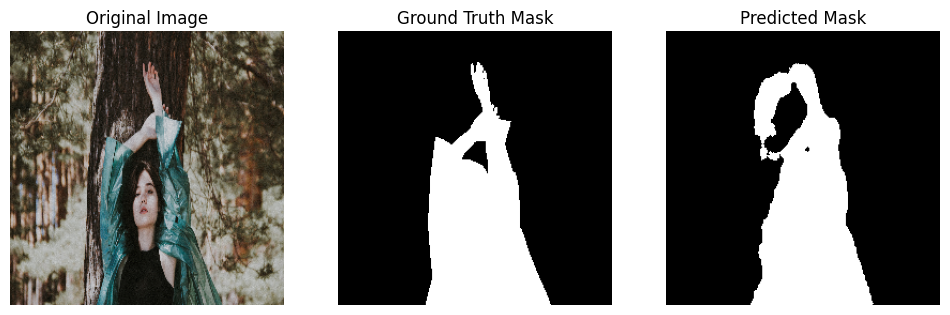

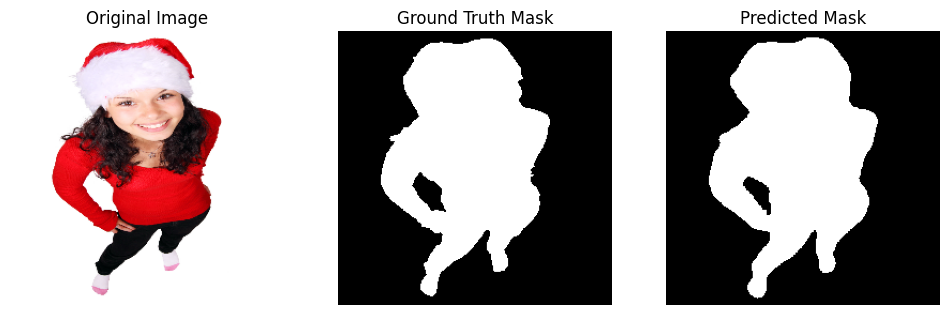

In [8]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, device):
    model.eval()
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            predictions = (outputs.sigmoid() > 0.5).float() 
            
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            predictions = predictions.cpu().numpy()
            
            for i in range(len(images)):
                img = np.transpose(images[i], (1, 2, 0))  
                gt_mask = masks[i][0]  
                pred_mask = predictions[i][0]  
                
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 3, 1)
                plt.imshow(img/255.0)
                plt.title("Original Image")
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(gt_mask, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis('off')
                
                plt.show()
                break  
                
visualize_predictions(model, test_loader, device)
